In [ ]:
import numpy as np

def from_rpy_to_angles(roll, pitch, yaw):
    """
    Convert roll, pitch, yaw angles to bending angle theta and directional angle phi.
    """
    phi = np.arctan2(3 * (pitch - yaw), np.sqrt(3) * (pitch + yaw - 2 * roll))
    theta = 2 * np.sqrt(roll**2 + pitch**2 + yaw**2 - roll * pitch - roll * yaw - pitch * yaw) / (3 * 60 / np.sqrt(3))
    return phi, theta

def compute_rotation_matrix(phi, beta):
    """
    Compute the rotation matrix based on given angles.
    """
    a = np.cos(beta) * np.cos(phi)**2 + np.sin(phi)**2
    b = (-1 + np.cos(beta)) * np.cos(phi) * np.sin(phi)
    c = np.cos(phi) * np.sin(beta)
    d = np.sin(beta) * np.sin(phi)
    e = np.cos(beta)
    f = np.cos(beta) * np.sin(phi)**2 + np.cos(phi)**2

    return np.array([[a, b, c], [b, f, d], [-c, -d, e]])

def transformed_vector(rho, beta, phi, rigid_len):
    """
    Compute transformed vector for the end position of a segment.
    """
    ptr = (1 / rho) * np.array([(1 - np.cos(beta)) * np.cos(phi), 
                                (1 - np.cos(beta)) * np.sin(phi), 
                                np.sin(beta)])
    rot = compute_rotation_matrix(phi, beta)
    dir_vec = np.dot(rot, np.array([0, 0, 1]))
    end_pos = ptr + dir_vec * rigid_len
    return end_pos, np.vstack((np.hstack((rot, end_pos.reshape(-1, 1))), [0, 0, 0, 1]))

import numpy as np

def compute_final_position(l1, l2, l3, d=19, e=0):
    """
    Compute the final tip position (x, y, z) from actuator lengths using PCC assumption.
    
    Parameters:
    - l1, l2, l3: Actuator lengths (mm)
    - d: Radius of actuator placement (mm) [default: 19]
    - e: Distance from projection point P1 to tip P (mm) [default: 0]
    
    Returns:
    - x, y, z: Final tip position in Cartesian coordinates (mm)
    """
    # Compute projection point P1
    lavg = (l1+l2+l3)/3
    dl1 = l1 -lavg
    dl2 = l2 -lavg
    dl3 = l3 -lavg
    x1 = (2 / 3) * d * (dl1 - 0.5 * dl2 - 0.5 * dl3)
    y1 = (2 / 3) * d * ((np.sqrt(3) / 2) * (dl2 - dl3))
    z1 = lavg  # Assumed centerline height

    # Compute arc parameters
    phi = np.arctan2(y1, x1)
    rho = (x1**2 + y1**2 + z1**2) / (2 * np.sqrt(x1**2 + y1**2))
    theta = np.arccos(1 - np.sqrt(x1**2 + y1**2) / rho) if z1 > 0 else 2 * np.pi - np.arccos(1 - np.sqrt(x1**2 + y1**2) / rho)

    # Compute final Cartesian position (x, y, z)
    x = x1 + e * np.sin(theta) * np.cos(phi)
    y = y1 + e * np.sin(theta) * np.sin(phi)
    z = z1 + e * np.cos(theta)

    return x, y, z



In [32]:
# Example usage with arbitrary actuator lengths
l1, l2, l3 = 60, 80, 100  # Example lengths
final_position = compute_final_position(l1, l2, l3)
final_position

(-380.0, -219.39310229205776, 80.0)

In [6]:
import numpy as np
from scipy.optimize import fsolve, root

def constant_curvature(p):
    x = p[0]
    y = p[1]
    z = p[2]
    d = 19  # Distance from the center of the chamber to the center of the base platform (mm)
    aa = 0  # Fixed distance from the base to the cross-section of the chamber

    # Special case: If the position is at the origin (0, 0), return straight lengths
    if x == 0 and y == 0:
        q1 = (z - aa) 
        q2 = (z - aa) 
        q3 = (z - aa)
        return np.array([q1, q2, q3])

    # Calculate the angle in the XY plane
    phi = np.arctan2(y, x)
    # Initial guess for the solver
    initial_guess = [x, y, z, 1.0, 0.1]  # Adjusted initial guess

    # Define the nonlinear equations to solve
    def nonlinear_equations(variables):
        x0, y0, z0, k0, theta0 = variables
        f = np.zeros(5)
        f[0] = 2 * np.sqrt(x0**2 + y0**2) / (x0**2 + y0**2 + z0**2) - k0
        f[1] = np.arccos(np.clip(1 - k0 * np.sqrt(x0**2 + y0**2), -1, 1)) - theta0
        f[2] = x0 + aa * np.sin(theta0) * np.cos(phi) - x
        f[3] = y0 + aa * np.sin(theta0) * np.sin(phi) - y
        f[4] = z0 + aa * np.cos(theta0) - z
        return f

    # Solve the nonlinear equations using fsolve
    try:
        solution = fsolve(nonlinear_equations, initial_guess, xtol=1e-12, maxfev=int(1e8))
    except Exception as e:
        print("Fsolve failed with exception:", e)
        return np.array([np.nan, np.nan, np.nan])

    # Extract real parts of the solution
    x1, y1, z1, k, theta = solution

    # Calculate the radii of curvature for each chamber
    R1 = 1 / k - d * np.sin(phi)
    R2 = 1 / k + d * np.sin(np.pi / 3 + phi)
    R3 = 1 / k - d * np.cos(np.pi / 6 + phi)

    # Calculate the length changes for each chamber
    q1 = float(theta * R1)
    q2 = float(theta * R2)
    q3 = float(theta * R3)

    return np.array([q1, q2, q3])



In [8]:
# Example usage with arbitrary actuator lengths
x, y, z = 40, 50, 60  # Example lengths
p = [x,y,z]
final_length = constant_curvature(p)
final_length

array([ 74.08498492, 127.303022  ,  93.67460543])

In [34]:
import numpy as np

def from_rpy_to_angles(rpy, l):
    """
    Convert roll-pitch-yaw angles to bending and directional angles.
    
    Parameters:
    rpy : list or numpy array of [roll, pitch, yaw] in degrees
    l : float, length parameter
    
    Returns:
    theta : float, bending angle in radians
    phi : float, directional angle in radians
    T : numpy array, transformation vector
    """
    roll, pitch, yaw = np.radians(rpy)  # Convert degrees to radians

    # Define unit vectors
    z = np.array([0, 0, 1])
    y = np.array([0, 1, 0])
    x = np.array([1, 0, 0])

    # Rotation matrices
    R_roll = np.array([[1, 0, 0], 
                       [0, np.cos(roll), -np.sin(roll)], 
                       [0, np.sin(roll), np.cos(roll)]])
    
    R_pitch = np.array([[np.cos(pitch), 0, np.sin(pitch)], 
                        [0, 1, 0], 
                        [-np.sin(pitch), 0, np.cos(pitch)]])
    
    R_yaw = np.array([[np.cos(yaw), -np.sin(yaw), 0], 
                      [np.sin(yaw), np.cos(yaw), 0], 
                      [0, 0, 1]])

    # Compute final rotation matrix
    R = R_yaw @ R_pitch @ R_roll

    # Compute transformed z vector
    n = R @ z
    p = np.array([np.dot(n, x) / np.linalg.norm(x), 
                  np.dot(n, y) / np.linalg.norm(y), 
                  0])

    # Compute angles in radians
    theta = np.arccos(np.dot(n, z) / np.linalg.norm(z))
    phi = np.arccos(np.dot(n, x) / (np.linalg.norm(x) * np.linalg.norm(p))) - np.pi / 2

    # Compute translation vector
    xy_proj = p / np.linalg.norm(p) * np.tan((np.pi - theta) / 2)
    r = l / theta
    T = np.array([xy_proj[0], xy_proj[1], np.sin(theta) * r])

    return theta, phi, T


In [35]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rotation_matrix(phi, beta):
    """
    Compute rotation matrix for given phi and beta.
    """
    a = np.cos(beta) * np.cos(phi)**2 + np.sin(phi)**2
    b = (-1 + np.cos(beta)) * np.cos(phi) * np.sin(phi)
    c = np.cos(phi) * np.sin(beta)
    d = np.sin(beta) * np.sin(phi)
    e = np.cos(beta)
    f = np.cos(beta) * np.sin(phi)**2 + np.cos(phi)**2

    return np.array([[a, b, c], [b, f, d], [-c, -d, e]])

def calc_displacement(rho, beta, phi):
    """
    Calculate displacement vector.
    """
    return (1 / rho) * np.array([(1 - np.cos(beta)) * np.cos(phi),
                                 (1 - np.cos(beta)) * np.sin(phi),
                                 np.sin(beta)])

def find_center(start, ends, st_dir, beta):
    """
    Find the center of the circular motion.
    """
    d = ends - start
    d_len = np.linalg.norm(d)
    norms = np.cross(d, st_dir)
    rad = np.cross(st_dir, norms)
    rad = rad / np.linalg.norm(norms) * (d_len / (2 * np.sin(beta / 2)))
    return rad + start

def draw_circle(ax, start_pos, start_ang, center, beta):
    """
    Draw a circular arc for the robotic arm motion.
    """
    beta_vec = np.linspace(0, beta, 1000)
    radi = start_pos - center
    r = np.linalg.norm(radi)

    ini_x = r * np.cos(beta_vec)
    ini_y = r * np.sin(beta_vec)
    ini_z = np.zeros(1000)

    normal = np.cross(radi, start_ang)
    normal = normal / np.linalg.norm(normal)
    new_x = radi / np.linalg.norm(radi)
    new_y = np.cross(normal, new_x)
    Rot = np.column_stack((new_x, new_y, normal))

    ini_cir = np.vstack((ini_x, ini_y, ini_z))
    new_cir = Rot @ ini_cir
    new1 = center[0] + new_cir[0, :]
    new2 = center[1] + new_cir[1, :]
    new3 = center[2] + new_cir[2, :]

    ax.plot3D(new1, new2, new3, 'r-', linewidth=2)
    ax.plot3D([center[0], new1[-1]], [center[1], new2[-1]], [center[2], new3[-1]], 'g--', linewidth=1)
    ax.plot3D([center[0], new1[0]], [center[1], new2[0]], [center[2], new3[0]], 'g--', linewidth=1)

def draw_arm_sec(ax, st, ends, st_dir, beta):
    """
    Draw an arm segment with a circular arc.
    """
    center = find_center(st, ends, st_dir, beta)
    draw_circle(ax, st, st_dir, center, beta)




End-effector position: [ 94.56914108 -85.19610273 196.9568623 ]


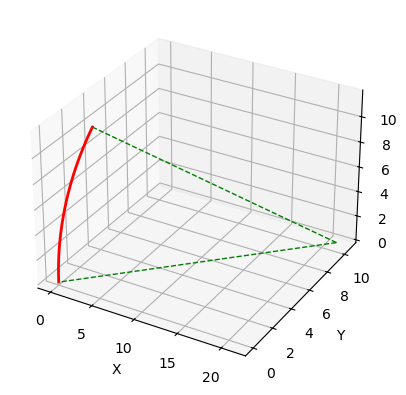

In [36]:
# Example usage
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Example start and end positions
start = np.array([0, 0, 0])
ends = np.array([10, 5, 5])
start_direction = np.array([0, 0, 1])
beta_angle = np.pi / 6  # 30 degrees

draw_arm_sec(ax, start, ends, start_direction, beta_angle)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rotation_matrix(phi, beta):
    """
    Compute the rotation matrix given phi and beta angles.
    """
    a = np.cos(beta) * np.cos(phi)**2 + np.sin(phi)**2
    b = (-1 + np.cos(beta)) * np.cos(phi) * np.sin(phi)
    c = np.cos(phi) * np.sin(beta)
    d = np.sin(beta) * np.sin(phi)
    e = np.cos(beta)
    f = np.cos(beta) * np.sin(phi)**2 + np.cos(phi)**2

    return np.array([[a, b, c], [b, f, d], [-c, -d, e]])

def calc_displacement(rho, beta, phi):
    """
    Calculate displacement vector.
    """
    return (1 / rho) * np.array([(1 - np.cos(beta)) * np.cos(phi),
                                 (1 - np.cos(beta)) * np.sin(phi),
                                 np.sin(beta)])

def get_beta(l1, l2, l3, r):
    """
    Calculate beta angles from segment lengths.
    """
    return 2 * np.sqrt(l1**2 + l2**2 + l3**2 - l1*l2 - l1*l3 - l2*l3) / (3 * r)

def get_phi(l1, l2, l3):
    """
    Calculate phi angles from segment lengths.
    """
    return np.arctan2(3*(l2 - l3), np.sqrt(3)*(l2 + l3 - 2 * l1))

def get_lks(lc, r, beta, phi):
    """
    Compute the corrected lengths.
    """
    return np.array([lc, lc, lc]) - r * beta * np.array([np.cos(-phi), np.cos(2*np.pi/3 - phi), np.cos(4*np.pi/3 - phi)])

def length_to_position(l1, l2, l3, rigid_len, r):
    """
    Convert segment lengths to final end-effector position.
    """
    # Compute parameters
    phi1 = get_phi(l1[0], l1[1], l1[2])
    phi2 = get_phi(l2[0], l2[1], l2[2])
    
    beta1 = get_beta(l1[0], l1[1], l1[2], r)
    beta2 = get_beta(l2[0], l2[1], l2[2], r)
    
    lc1 = np.mean(l1)
    lc2 = np.mean(l2)
    
    rho1 = beta1 / lc1
    rho2 = beta2 / lc2

    # Compute initial section
    ptr1 = calc_displacement(rho1, beta1, phi1)
    rot1 = compute_rotation_matrix(phi1, beta1)
    dir1 = rot1 @ np.array([0, 0, 1])
    base1 = ptr1 + dir1 * rigid_len

    # Compute second section
    ptr2 = calc_displacement(rho2, beta2, phi2)
    ptr2_transformed = rot1 @ ptr2 + base1  # Apply transformation
    rot2 = compute_rotation_matrix(phi2, beta2)
    dir2 = rot2 @ dir1
    base2 = ptr2_transformed + dir2 * rigid_len

    return base2  # Final position

# Example usage
l1 = [60, 80, 100]
l2 = [70, 50, 70]
rigid_len = 49
r = 60 / np.sqrt(3)

end_effector_pos = length_to_position(l1, l2, l3, rigid_len, r)
print("End-effector position:", end_effector_pos)


End-effector position: [ 94.56914108 -85.19610273 196.9568623 ]


In [16]:
import numpy as np

def compute_rotation_matrix(phi, beta):
    """
    Compute the rotation matrix given phi and beta angles.
    
    Parameters:
    phi : float - Directional angle (radians)
    beta : float - Bending angle (radians)
    
    Returns:
    3x3 rotation matrix (numpy array)
    """
    a = np.cos(beta) * np.cos(phi)**2 + np.sin(phi)**2
    b = (-1 + np.cos(beta)) * np.cos(phi) * np.sin(phi)
    c = np.cos(phi) * np.sin(beta)
    d = np.sin(beta) * np.sin(phi)
    e = np.cos(beta)
    f = np.cos(beta) * np.sin(phi)**2 + np.cos(phi)**2

    return np.array([[a, b, c], [b, f, d], [-c, -d, e]])

def calc_displacement(rho, beta, phi):
    """
    Compute the displacement vector based on curvature parameters.
    
    Parameters:
    rho : float - Curvature
    beta : float - Bending angle (radians)
    phi : float - Directional angle (radians)
    
    Returns:
    3D displacement vector (numpy array)
    """
    return (1 / rho) * np.array([(1 - np.cos(beta)) * np.sin(phi),
                                 (1 - np.cos(beta)) * np.cos(phi),
                                 np.sin(beta)])

def get_beta(l1, l2, l3, r):
    """
    Compute the bending angle beta from segment lengths.
    
    Parameters:
    l1, l2, l3 : float - Three segment lengths
    r : float - Radius parameter
    
    Returns:
    Beta (float) - Bending angle in radians
    """
    return 2 * np.sqrt(l1**2 + l2**2 + l3**2 - l1*l2 - l1*l3 - l2*l3) / (3 * r)

def get_phi(l1, l2, l3):
    """
    Compute the directional angle phi from segment lengths.
    
    Parameters:
    l1, l2, l3 : float - Three segment lengths
    
    Returns:
    Phi (float) - Directional angle in radians
    """
    return np.arctan2(3 * (l2 - l3), np.sqrt(3) * (l2 + l3 - 2 * l1))

def length_to_position_single(l, rigid_len, r):
    """
    Compute the end-effector position for a single segment.
    
    Parameters:
    l : list - Three segment lengths [l1, l2, l3]
    rigid_len : float - Length of the rigid body
    r : float - Radius parameter
    
    Returns:
    3D end-effector position (numpy array)
    """
    # Compute parameters
    phi = get_phi(l[0], l[1], l[2])
    beta = get_beta(l[0], l[1], l[2], r)
    lc = np.mean(l)  # Average segment length
    rho = beta / lc  # Curvature

    # Compute displacement and rotation
    displacement = calc_displacement(rho, beta, phi)
    rotation = compute_rotation_matrix(phi, beta)
    direction = rotation @ np.array([0, 0, 1])  # Transform the direction

    # Compute final position
    end_position = displacement + direction * rigid_len
    #end_position_final = [end_position[1], end_position[0], end_position[2]]
    #return end_position_final
    return end_position



In [18]:
# Example usage
l = [74.08498492,127.303022,93.67460543]  # Example segment lengths
rigid_len = 0    # Rigid body length
r = 19 #60 / np.sqrt(3)  # Radius parameter

end_effector_pos = length_to_position_single(l, rigid_len, r)
print("End-effector position:", end_effector_pos)

End-effector position: [40. 50. 60.]
